# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:

import numpy as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use("dark_background")

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


In [ ]:

p = pd.read_csv('/datasets/faces/labels.csv')



In [ ]:
p.head()



,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
p.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В данных нет пропусков, всего в датасете 7591 запись. Посмотрим на распределение возраста по выборке.



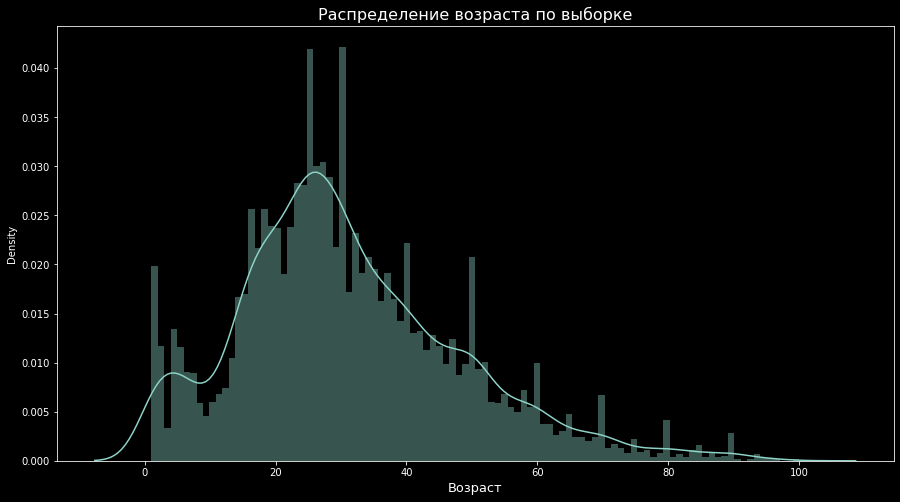

In [ ]:
plt.figure(figsize=(15,8))
sns.distplot(p['real_age'], bins=100)
plt.title('Распределение возраста по выборке', size=16)
plt.xlabel('Возраст', size=13);




Возраст в колонке с целевым признаком — от года до 100. Больше всего людей — в возрасте от 20 до 50 лет, пиковые значения — в районе 30 лет.

Напечатаем на экране несколько фотографий.



Found 7591 validated image filenames.


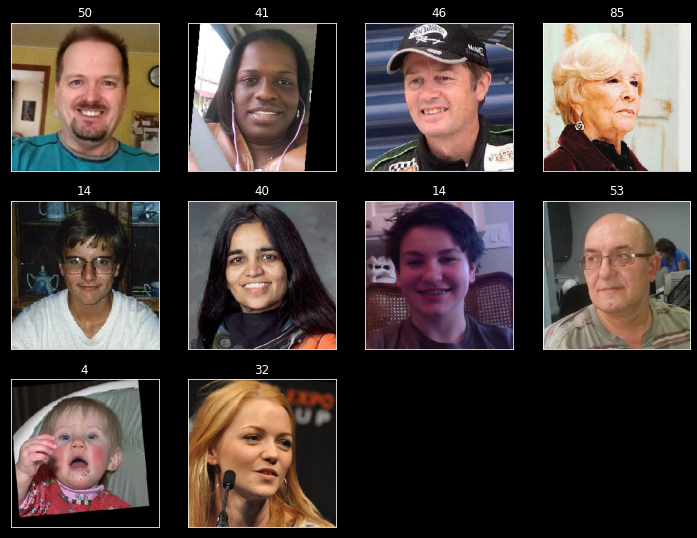

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=p,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=10,
        class_mode='raw',
        seed=12345)

features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1).title.set_text(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод по разделу

В датасете 7591 запись. Пропусков нет.

Возраст в колонке с целевым признаком — от года до 100. Больше всего людей — в возрасте от 20 до 50 лет, пиковые значения — в районе 30 лет.

По выведенным изображениям мы видим, что в нашем наборе присутствуют фотографии разного качества. Кроме того, портреты сделаны с разных ракурсов (профиль, анфас) и с разной мимикой (улыбка, без улыбки), есть портреты, на которых человек запечатлен в очках, наушниках, кепке. Таким образом, данные фотографии приближены к реальности. Если модель будет обучена на таких фотографиях, то ей будет проще распознавать лица реальных людей в жизни.


## Обучение модели

Код из этом раздела запускается в отдельном GPU-тренажёре.

```

import pandas as pd

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

p = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):

    train_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2
        )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=p,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    test_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255
        )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=p,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, 
                epochs=5, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
                 steps_per_epoch = len(train_data)
    if validation_steps is None:
                  validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,        
              verbose=2, 
              shuffle=True)

    return model
    


```
Train for 380 steps, validate for 95 steps
Epoch 1/5
2023-03-31 19:16:09.925108: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-31 19:16:10.434677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 120s - loss: 11.6051 - mae: 11.6108 - val_loss: 21.3554 - val_mae: 21.3519
Epoch 2/5
380/380 - 112s - loss: 8.7563 - mae: 8.7580 - val_loss: 9.9798 - val_mae: 9.9779
Epoch 3/5
380/380 - 106s - loss: 8.0955 - mae: 8.0969 - val_loss: 7.3531 - val_mae: 7.3525
Epoch 4/5
380/380 - 106s - loss: 7.5085 - mae: 7.5125 - val_loss: 8.3820 - val_mae: 8.3820
Epoch 5/5
380/380 - 104s - loss: 7.2678 - mae: 7.2723 - val_loss: 7.5561 - val_mae: 7.5552
```

## Анализ обученной модели

Для работы с изображениями мы использовали модель на базе архитектуры ResNet50.

Для повышения качества модели обучающая выборка была подвергнута аугментации: отражение по горизонтали, отражение по вертикали, поворот на 90 градусов, сдвиги до 45% от исходного размера.

Модель строилась на базе ResNet50, предобученной на наборе данных _imagenet_. Мы использовали каркас модели (backbone) с весами _imagenet_, а верхушка была сконструирована с учетом нашей задачи регрессии (полносвязный слой с одним выходным нейроном, способ активации — _relu_). Мы установили размер батча, равный 16. Использовался оптимизатор _Adam_ с параметром _learning_rate_ = 0.0001.

На тестовом наборе данных на пяти эпохах модель показала _MAE_, равный 7.5552. Переобучения выявлено не было.

## Вывод

Целью проекта было построение модели регрессии для определения приблизительного возраста покупателей. Для этого были использованы данные, в которых содержалась 7591 фотография и целевой признак (возраст). В колонке с возрастом больше всего значений приходится на промежуток от 20 до 50 лет, пиковые значения — в районе 30 лет, диапазон — от 1 до 100 лет. В имеющемся датасете были фотографии разного качества, с разных ракурсов, с присутствием очков, головных уборов, наушников и других предметов, которые могут мешать работе модели, но вместе с тем при использовании модели в реальной жизни это окажется полезным и может повысить качество предсказаний.

Для работы с данными изображениями мы использовали модель на базе архитектуры ResNet50.

Для повышения качества модели обучающая выборка была подвергнута аугментации.

Модель строилась на базе ResNet50, предобученной на наборе данных _imagenet_. 

На тестовом наборе данных на пяти эпохах модель показала _MAE_, равный 7.5552, что соответствует поставленной задаче.
